# Trả lời câu hỏi `Những thuộc tính nào ảnh hưởng đến độ ẩm của không khí? dự đoán độ ẩm không khí vào một thời điểm cụ thể.`

## Mô hình dự đoán độ ẩm tại một thời điểm 
- Sử dụng mô hình hồi quy tuyến tính để dự đoán độ ẩm tương đối trong tương lai dựa vào một số dữ liệu có thể dự đoán trước được 
- Độ ẩm trong một ngày có ý nghĩa quan trọng trong đời sống thường nhật, yếu tố này ảnh hưởng đến sức khỏe con người, các yếu tố bị ảnh hưởng bởi độ ẩm bao gồm các thiết bị điện tử, hiện tượng ẩm mốc, nhiệt độ cảm giác của con người (feels like), ...
- Trả lời câu hỏi bằng mô hình sẽ cho chúng ta ước lượng được độ ẩm tương đối trong một ngày cao hay thấp để có những kế hoạch để bảo vệ sức khỏe, bảo vệ đồ đạc trong nhà và các yếu tố liên quan. 
## Mô hình hồi quy tuyến tính
- Là mô hình đi tìm các tham số cho hàm số có dạng 
$y = w_{1}x_{1} + w_{2}x_{2} + ... + w_{n}x_{n}$
- với $w_1, w_2,...$ là các tham số cần tìm, chúng ta sẽ dựa vào hàm lỗi để giảm thiểu sai số của hàm tuyến tính này đối với tập dữ liệu

# Lấy các module cần thiết 

In [1]:
import joblib
import numpy as np
import pandas as pd
from pandas.core.common import random_state
# from pandas.io.common import tarfile
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, KFold


# from pandas.core.array_algos.replace import compare_or_regex_search
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Lấy các file dữ liệu

In [2]:
TARGET = 'Humidity'

In [3]:
def get_file_list():
    # Import module cần thiết
    import os

    # Chỉ định thư mục
    directory = "../../../data/clean_data/"

    # Iterate các tập tin trong thư mục đó
    result = [f[:-4] for f in os.listdir(directory) if f[0] != '.' ]
    return result

In [4]:
LOCATIONS_LIST = get_file_list()
LOCATIONS_LIST

['BenTre',
 'DaNang',
 'HaNoi',
 'HoChiMinh',
 'LamDong',
 'LangSon',
 'NgheAn',
 'SonLa']

# Đọc dữ liệu từ các file 

In [5]:
def read_location_data(loc_list):
    result = [pd.read_csv(f"../../../data/clean_data/{loc}.csv") for loc in loc_list]
    return result

In [6]:
df_list = read_location_data(LOCATIONS_LIST)
# Gộp dữ liệu các tỉnh lại thành 1 dataframe
result_df = pd.concat(
    [df.select_dtypes(exclude="object") for df in df_list], ignore_index=True
)
# Lấy ma trận hệ số tương quan 
corr_mat = result_df.corr()

In [7]:
print(result_df.head())

   DatetimeEpoch  Tempmax  Tempmin  Temp   Dew  Humidity  Precip  Precipprob  \
0     1546275600     27.7     24.0  25.8  19.2      66.9     2.7       100.0   
1     1546362000     25.0     23.5  24.1  20.8      81.5    26.5       100.0   
2     1546448400     28.3     23.7  26.2  21.8      77.1     0.1       100.0   
3     1546534800     32.1     25.5  28.3  22.6      72.4     1.2       100.0   
4     1546621200     32.6     25.0  28.2  22.0      70.2     0.0         0.0   

   Precipcover  Windgust  Windspeed  Winddir  Pressure  Cloudcover  \
0        29.17      36.4       18.4      3.2    1012.5        57.3   
1        83.33      56.9       14.4      3.5    1012.0        66.1   
2         4.17      62.6       17.8     47.6    1012.0        65.6   
3        33.33      60.1       30.3     88.8    1012.6        50.4   
4         0.00      45.4       27.3     97.8    1012.6        36.5   

   Visibility  Solarradiation  Solarenergy  Uvindex  Moonphase  
0        10.9            81.2    

In [8]:
print(corr_mat.head())

               DatetimeEpoch   Tempmax   Tempmin      Temp       Dew  \
DatetimeEpoch       1.000000 -0.024133 -0.066624 -0.060163 -0.043321   
Tempmax            -0.024133  1.000000  0.847693  0.948218  0.784363   
Tempmin            -0.066624  0.847693  1.000000  0.963428  0.929718   
Temp               -0.060163  0.948218  0.963428  1.000000  0.892332   
Dew                -0.043321  0.784363  0.929718  0.892332  1.000000   

               Humidity    Precip  Precipprob  Precipcover  Windgust  \
DatetimeEpoch  0.042264  0.033192    0.047554     0.007081 -0.219202   
Tempmax       -0.299584 -0.049144   -0.050351    -0.207742  0.022236   
Tempmin       -0.032962  0.064054    0.140102    -0.097877  0.136586   
Temp          -0.185899  0.006841    0.034923    -0.176230  0.092387   
Dew            0.273854  0.130652    0.275494     0.010557  0.091838   

               Windspeed   Winddir  Pressure  Cloudcover  Visibility  \
DatetimeEpoch   0.005288  0.031227 -0.019106    0.033230    0.

# Phân tích dữ liệu trước khi modeling
## Quan sát sự tương quan giữa các thuộc tính với nhau 
- Trước khi thực hiện bước modeling, chúng ta quan sát các thuộc tính trong dữ liệu có mối quan hệ gì với nhau.
- Thực hiện điều này sẽ cho ta thấy sự tương tác tương đối giữa các cặp dữ liệu với nhau
## Hệ số tương quan 
$r = \frac{\sum (X_i - \bar{X})(Y_i - \bar{Y})}{\sqrt{\sum (X_i - \bar{X})^2 \sum (Y_i - \bar{Y})^2}}$

- với mỗi $X_i, Y_i$ là những điểm dữ liệu trong từng cặp thuộc tính 
- khi r > 0 tức là cặp thuộc tính có mối tương quan dương và ngược lại 
- Độ lớn của gía trị này thể hiện mức độ tương quan giữa cặp thuộc tính 

In [9]:
def plot_corr_matrix(corr_mat):
    # Import module cho việc vẽ ma trận tương quan
    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.heatmap(corr_mat, cmap="coolwarm", linewidths=0.5)
    # un-comment this when use in ipynb
    plt.show()
    # comment this when use in notebook
    #plt.show(block=True)

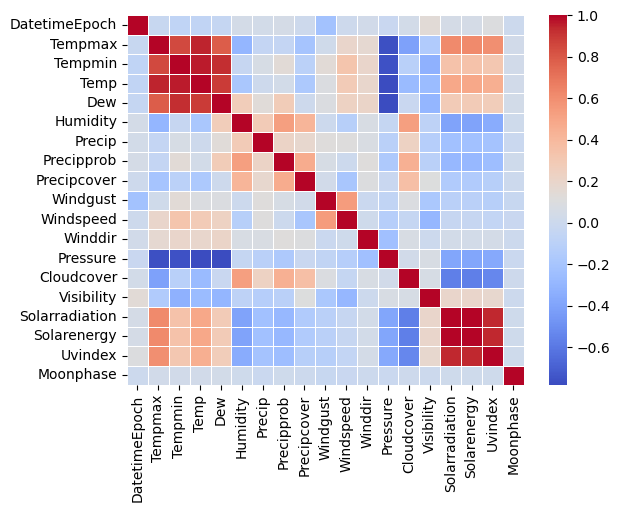

In [10]:
plot_corr_matrix(corr_mat)

# Lấy các dữ liệu có hệ số tương quan cao 
- Khi ta đã trực quan hóa sự tương quan của thuộc tính độ ẩm đối với các thuộc tính còn lại 
- Ta thấy được thuộc tính này không có sự tương quan quá mạnh đối với các thuộc tính khác (lưu ý: đây chỉ là hệ số tương quan giữa 1 cặp thuộc tính 1-1, không đem lại quá nhiều ý nghĩa trong việc chọn thuộc tính nhưng cũng là một điểm khởi đầu tương đối)
- Vì vậy ta sẽ hạ cận trên của hệ số tương quan để lấy đủ các thuộc tính cho model 

In [11]:
def get_high_curr_attri(corr_mat):
    threshold = 0.1
    temp_df = corr_mat[TARGET]
    result = [
        temp_df.index[val]
        for val, i in enumerate(temp_df)
        if abs(i) >= threshold and i != 1.0
    ]

    return result

# Về 2 thuộc tính ngoại lệ 
- Vì Dew là một thuộc tính suy diễn và Tempmax không thể dự đoán chính xác bằng các phương pháp thông thường nên chúng ta sẽ loại bỏ 2 thuộc tính này ra khỏi các thuộc tính 

In [12]:
attri_list = get_high_curr_attri(corr_mat)
# không thể lấy dew vì đây là thuộc tính suy diễn 
attri_list.remove('Dew')
attri_list.remove('Tempmax')
print(attri_list)

['Temp', 'Precip', 'Precipprob', 'Precipcover', 'Windspeed', 'Cloudcover', 'Solarradiation', 'Solarenergy', 'Uvindex']


# Về các thuộc tính đã chọn và cách có được các thuộc tính này 
- Temp: Chúng ta đã có được một số mô hình dự đoán nhiệt độ và có thể dự đoán tương đối dữ liệu này 
- Precip, Precipprob, Precipcover, Cloudcover: Các thuộc tính liên quan đến mưa có thể được dự đoán và tính toán thông qua các vệ tinh để lấy dữ liệu hình ảnh về các đám mây cũng như dự đoán được độ dày, mức độ che phủ của mây 
- Solarradiation, Solarenergy, Uvindex: dựa vào độ che phủ của mây, nồng độ Ozone khí quyển, mùa trong năm ta có thể có được con số khá chính xác về mức độ mạnh yếu của năng lượng mặt trời

In [13]:
print(attri_list)

['Temp', 'Precip', 'Precipprob', 'Precipcover', 'Windspeed', 'Cloudcover', 'Solarradiation', 'Solarenergy', 'Uvindex']


# Bước modeling 


## Hàm Calc_loss()
Hàm này sẽ nhận một pipeline và tính bảng r2 score bằng phương pháp cross validation \
R² (R-squared) là một chỉ số trong mô hình hồi quy dùng để đo lường mức độ phù hợp của mô hình với dữ liệu thực tế. Nó thể hiện tỷ lệ phương sai giữa output và input trong mô hình. Chỉ số này có giá trị trong khoảng từ 0 đến 1, có ý nghĩa như sau:

- R² = 1: Mô hình hoàn hảo, tức là tất cả dữ liệu thực tế đều được mô hình dự đoán chính xác.
- R² = 0: Mô hình không giải thích được gì về dữ liệu, nghĩa là mô hình không khác gì việc dự đoán trung bình của biến phụ thuộc.
- 0 < R² < 1: Mô hình có khả năng dự đoán một phần của dữ liệu. Càng gần 1, mô hình càng tốt.

Công thức tính R² là: \
$$R^{2} = 1 - \frac{\sum(y_{i}-\hat y_{i})^{2}}{\sum(y_{i}-\bar{y_{i}})^{2}}$$
- $y_{i}$ là giá trị thực tế. 
- $\hat y_{i}$ là giá trị dự đoán từ mô hình.
- $\bar{y_{i}}$ là giá trị trung bình của $y_{i}$​.

R² là một chỉ số quan trọng trong việc đánh giá hiệu quả của các mô hình hồi quy, giúp người dùng xác định mức độ chính xác của mô hình trong việc giải thích sự thay đổi của dữ liệu.

In [14]:
def calc_loss(pipe, X: pd.DataFrame, y: pd.DataFrame):
    cv_score = cross_val_score(pipe, X, y,
                               cv = KFold(n_splits=10,
                                          shuffle=True,
                                          random_state=42),
                               scoring="r2")
    cv_score = cv_score.round(4)

    return cv_score

## Hàm Modeling
- Hàm này sẽ nhận vào dữ liệu dưới dạng DataFrame và các thuộc tính được chọn làm tham số 
- Fit mô hình hồi quy tuyến tính vào tập dữ liệu 
về standardscaler:
tandardScaler (hay còn được biết là Z-score standardization) được dùng để chuẩn hóa dữ liệu, giúp đưa các đặc trưng (features) của dữ liệu về cùng một tỷ lệ (scale). Khi các dữ liệu có phạm vi hoặc đơn vị khác nhau, việc chuẩn hóa là rất quan trọng vì nó giúp các thuật toán học máy hoạt động hiệu quả hơn.

Công dụng chính của StandardScaler là chuẩn hóa các đặc trưng sao cho:

    Giá trị trung bình của các đặc trưng sau khi chuẩn hóa sẽ là 0.
    Độ lệch chuẩn (standard deviation) của các đặc trưng sau khi chuẩn hóa sẽ là 1.

Công thức chuẩn hóa sử dụng StandardScaler như sau:\
$$z = \frac{x-\mu}{\sigma}$$

Trong đó:

- $x$ là giá trị gốc của đặc trưng.
- $\mu$ là giá trị trung bình của đặc trưng.
- $\sigma$ là độ lệch chuẩn của đặc trưng.
- $z$ là giá trị đã được chuẩn hóa (z-score).

Các bước chuẩn hóa với StandardScaler:
- Tính toán trung bình (mean) và độ lệch chuẩn (standard deviation) của mỗi đặc trưng trong dữ liệu
- Chuẩn hóa mỗi giá trị đặc trưng bằng cách trừ đi trung bình và chia cho độ lệch chuẩn.


In [15]:
def modeling(result_df: pd.DataFrame, attri_list): 
    pipe = make_pipeline(StandardScaler(), LinearRegression())
    X = result_df[attri_list]
    y = result_df[TARGET]
    pipe.fit(X, y)

    return pipe

 # Giải thích quá trình 
 Sau khi đã lọc các thuộc tính không mong muốn, chúng ta bắt đầu thực hiện bước modeling: 
 ## Bước 1: chia dữ liệu với hàm train_test_split:
 - Hàm `train_test_split` trong thư viện scikit-learn (sklearn) được sử dụng để chia dữ liệu thành hai tập con: một tập huấn luyện (training set) và một tập kiểm tra (test set). Điều này rất quan trọng trong việc huấn luyện và đánh giá mô hình học máy, vì nó giúp đảm bảo rằng mô hình không bị overfitting (học quá kỹ từ dữ liệu huấn luyện) và có thể tổng quát tốt khi làm việc với dữ liệu chưa thấy (dữ liệu kiểm tra).
Cách thức hoạt động của train_test_split:

- Hàm này chia dữ liệu đầu vào thành hai phần:

    - Tập huấn luyện (Training set): Dùng để huấn luyện mô hình.
    - Tập kiểm tra (Test set): Dùng để đánh giá mô hình sau khi huấn luyện. 
    
- Các tham số của hàm bao gồm:

    - `X`: Dữ liệu đầu vào (features), thường là một ma trận 2 chiều.
    - `y`: Nhãn đầu ra (target), là một mảng 1 chiều chứa các giá trị cần dự đoán.
    - `test_size`: Tỷ lệ phân chia cho tập kiểm tra (test set). Ví dụ, nếu test_size=0.2, thì 20% dữ liệu sẽ được dùng cho kiểm tra và 75% còn lại sẽ được dùng cho huấn luyện.
    - `random_state`: Hạt giống (seed) ngẫu nhiên để đảm bảo kết quả phân chia là lặp lại. Nếu không có, mỗi lần chạy lại có thể sẽ phân chia dữ liệu khác nhau.

- Lý do việc chia tập dữ liệu:
    - giảm thiểu overfitting: loại bỏ dữ liệu test ra khỏi tập dữ liệu tránh việc mô hình sẽ "ghi nhớ" đáp án của tập test để giảm thiểu overfitting, đánh giá mô hình khách quan

 ## Bước 2: Tạo pipeline
- Đây là bước của module sklearn giúp chúng ta nhanh chóng tạo ra một chuỗi các xử lý để tạo ra model bao gồm các bước chuẩn hóa dữ liệu và mô hình tương ứng
- Giúp đơn giản hoá code và tránh lỗi 
 ## Đánh giá mô hình bằng việc tính r2score bằng cách gọi hàm calc_loss 
 ## Tạo ra mô hình cuối bằng việc gọi hàm modeling


In [16]:
X = result_df[attri_list]
y = result_df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=29049
)
# pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe = modeling(result_df, attri_list)
score = calc_loss(pipe, X, y)

# Đánh giá mô hình 
- Mặc dù điểm $r^2$ không cao tuy nhiên đây là một chủ đề có nhiều yếu tố ngẫu nhiên, khó đoán trước và thời tiết vốn là một yếu tố có mức độ hỗn loạn (entropy) cao 
- Con số 0.44193 có thể được coi là chấp nhận được nếu chúng ta chỉ dự đoán tương đối độ ẩm tương đối không lệch quá 20% - 30% 

In [17]:
print(score)
print(np.mean(score))

[0.4524 0.4451 0.4333 0.4481 0.4471 0.4374 0.4298 0.4741 0.4237 0.4327]
0.44237000000000004


# Sử dụng mô hình 
- Chúng ta sẽ trực quan hoá kết quả của mô hình thông qua scatter plot
- Các điểm dữ liệu nằm trên nét đứt màu đỏ là dự đoán chính xác với thực tế
- Nhìn chung các điểm dữ liệu dự đoán chính xác hơn với các ngày có độ ẩm cao
- Đủ sử dụng để dự đoán độ ẩm tương đối trong thực tế 

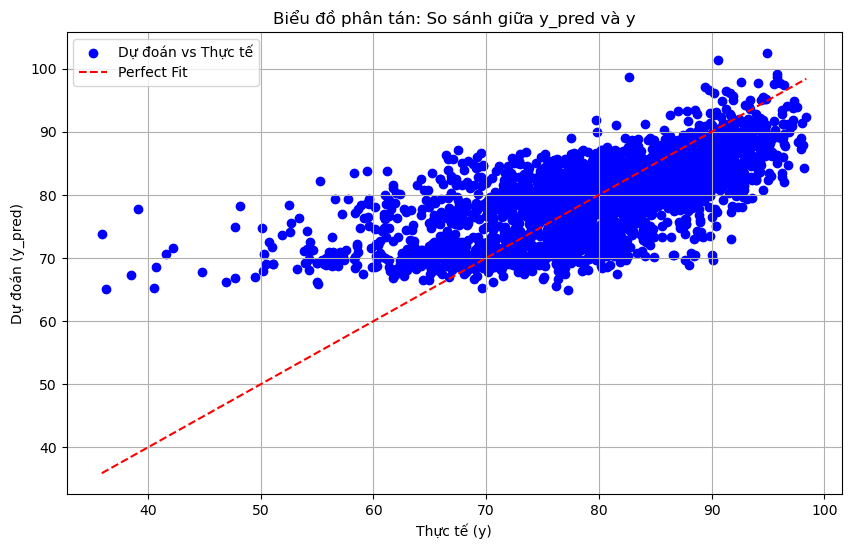

In [18]:
import matplotlib.pyplot as plt
y_pred = pipe.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Dự đoán vs Thực tế')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Fit')
plt.xlabel('Thực tế (y)')
plt.ylabel('Dự đoán (y_pred)')
plt.title('Biểu đồ phân tán: So sánh giữa y_pred và y')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
print(pipe.predict(X_test)[:50].round(1))

[80.2 77.8 79.7 84.8 78.2 70.7 86.6 75.5 79.9 79.3 72.6 77.4 83.7 84.8
 84.  70.8 85.9 95.6 79.3 84.7 74.2 87.8 91.1 73.6 77.2 85.7 87.1 97.5
 81.5 77.5 78.4 86.6 81.1 88.3 79.5 93.9 74.6 84.8 79.7 83.4 87.6 85.4
 85.  85.5 86.7 81.9 86.7 82.5 69.8 69.9]


In [20]:
print(np.array(y_test.head(50).to_list()))

[62.  87.8 73.4 87.5 80.3 75.7 79.7 81.9 61.  85.  61.7 78.3 59.4 69.7
 79.6 67.7 94.  91.9 83.6 87.  80.7 93.4 90.  81.5 79.4 85.5 92.2 95.5
 82.3 67.2 81.6 84.9 82.5 90.2 72.6 93.3 82.9 83.5 73.  80.1 88.1 81.
 92.1 83.5 85.9 74.5 81.4 88.7 70.5 67.2]
